# Derin Ogrenme (FET312) Final Projesi: DenseNet-121 ile Trafik Isareti Siniflandirma

Bu calisma, GTSRB (German Traffic Sign Recognition Benchmark) veri seti uzerinde derin ogrenme teknikleri uygulanarak gerceklestirilmistir. Projenin bu asamasinda, vize raporunda sunulan temel modellere ek olarak daha karmasik ve derin bir mimari olan **DenseNet-121** kullanilmistir. DenseNet mimarisi, katmanlar arasindaki yoğun baglantilar sayesinde gradyan akisini iyilestirerek daha yuksek basarim oranlari elde etmemize olanak tanimaktadir.

## 1. Kutuphanelerin Yuklenmesi
Projede veri isleme, gorsellestirme ve model egitimi icin PyTorch ekosistemi ve yardimci kutuphaneler kullanilmistir.

In [2]:

import sys
import torch
print("Python:", sys.executable)
print("Torch:", torch.__version__)
print("Torch CUDA:", torch.version.cuda)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Selected device:", device)

import os
import shutil

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import datasets, transforms, models

from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc

from tqdm import tqdm

Python: C:\Users\Lenovo\Derin Ogrenme Final\venv311\Scripts\python.exe
Torch: 2.1.0+cu121
Torch CUDA: 12.1
CUDA available: True
GPU: NVIDIA GeForce RTX 3060 Laptop GPU
Selected device: cuda


## 2. Konfigurasyon ve Veri Temizligi
Temel hiperparametrelerin tanimlanmasi bu adimda yapilmistir.

In [3]:
TRAIN_DATA_DIR = 'GTSRB/Final_Training/Images'
TEST_DATA_DIR = 'GTSRB_Final_Test/Final_Test/Images'
TEST_CSV_PATH = 'GT-final_test.csv'

BATCH_SIZE = 32
NUM_CLASSES = 43
LEARNING_RATE = 1e-4
EPOCHS = 15
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_PATH = "densenet121_gtsrb_clean.pth"

# Gereksiz .ipynb_checkpoints klasorlerini temizleme
for root, dirs, files in os.walk(TRAIN_DATA_DIR):
    for d in dirs:
        if d == ".ipynb_checkpoints":
            shutil.rmtree(os.path.join(root, d))

## 3. Veri Seti Analizi ve Sinif Dagilimi
Veri setinin boyut ve sinif dagilimi bilgileri analiz edilmistir. Siniflar arasindaki dengesizligi gozlemlemek adina histogram ve pasta grafigi (pie chart) kullanilmistir.

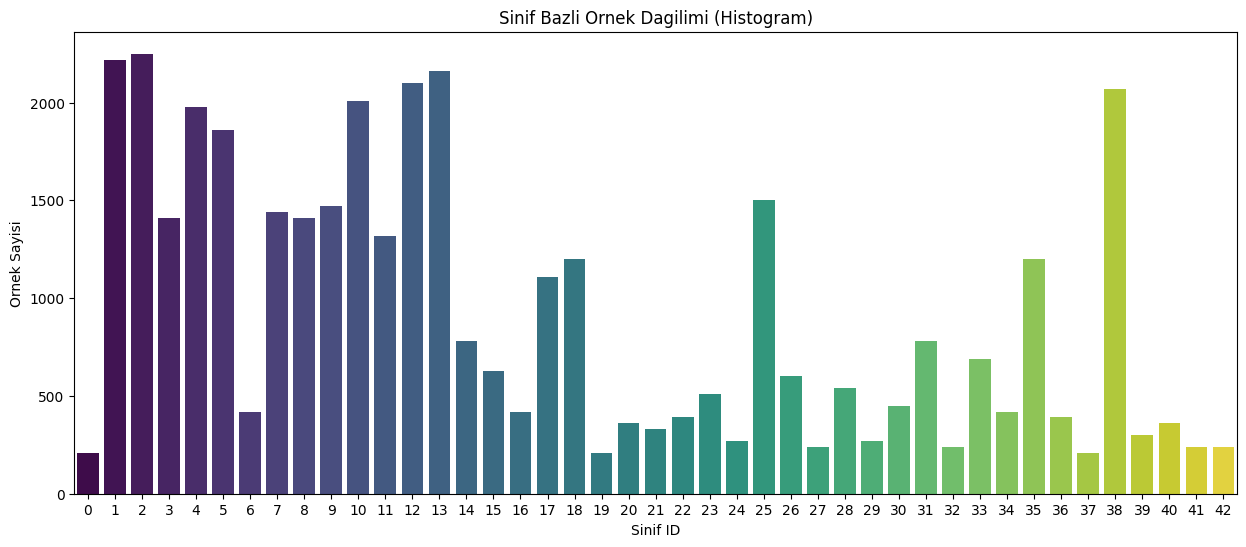

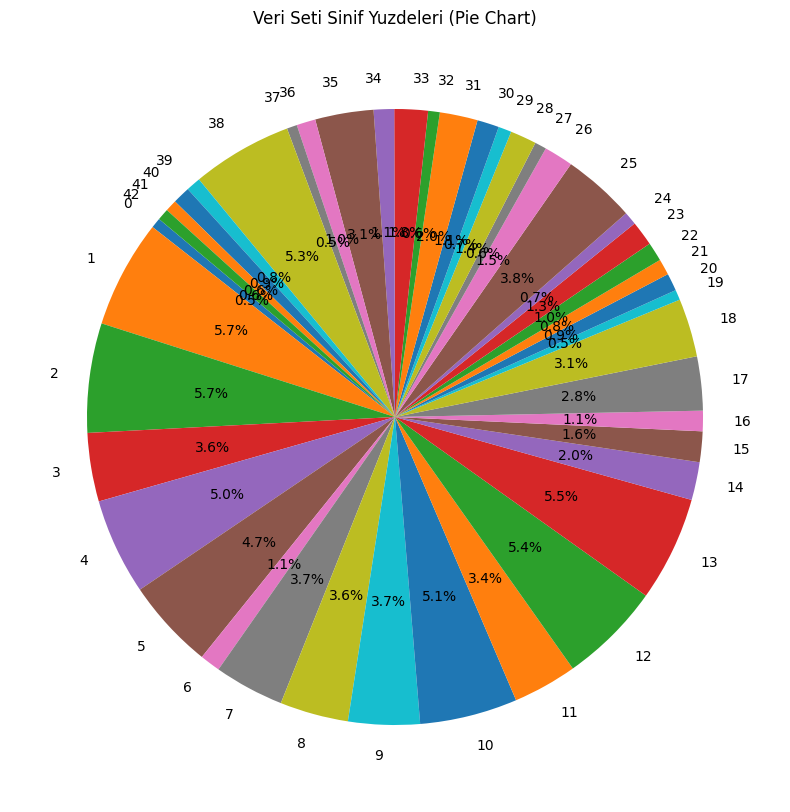

In [4]:
full_dataset = datasets.ImageFolder(TRAIN_DATA_DIR)
labels = [label for _, label in full_dataset.imgs]
label_counts = pd.Series(labels).value_counts().sort_index()

plt.figure(figsize=(15, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, hue=label_counts.index, palette="viridis", legend=False)
plt.title("Sinif Bazli Ornek Dagilimi (Histogram)")
plt.xlabel("Sinif ID")
plt.ylabel("Ornek Sayisi")
plt.show()

plt.figure(figsize=(10, 10))
plt.pie(label_counts.values, labels=label_counts.index, autopct='%1.1f%%', startangle=140)
plt.title("Veri Seti Sinif Yuzdeleri (Pie Chart)")
plt.show()

## 4. Veri On Isleme ve Veri Coklama (Data Augmentation)
Modelin genelleme yetenegini artirmak ve asiri ogrenmeyi (overfitting) engellemek amaciyla veri coklama teknikleri uygulanmistir. Bu kapsamda goruntuler 72x72 boyutuna getirilmis, rastgele dondurme ve renk titremesi islemleri yapilmistir.

In [5]:
train_tf = transforms.Compose([
    transforms.Resize((72, 72)),
    transforms.RandomResizedCrop(64, scale=(0.8, 1.0)),
    transforms.RandomRotation(15),
    transforms.ColorJitter(0.2, 0.2, 0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.3337, 0.3064, 0.3171], [0.2672, 0.2564, 0.2629])
])

test_tf = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.3337, 0.3064, 0.3171], [0.2672, 0.2564, 0.2629])
])

groups = []
for path, label in full_dataset.imgs:
    track_id = os.path.basename(path).split('_')[0]
    groups.append(f"{label}_{track_id}")

gss = GroupShuffleSplit(test_size=0.2, random_state=42)
train_idx, val_idx = next(gss.split(np.zeros(len(groups)), full_dataset.targets, groups))

train_ds = Subset(full_dataset, train_idx)
val_ds   = Subset(full_dataset, val_idx)
train_ds.dataset.transform = train_tf
val_ds.dataset.transform   = test_tf

train_loader = DataLoader(train_ds, BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds, BATCH_SIZE, shuffle=False)

## 5. Model Mimarisi: DenseNet-121
Gelismiş model olarak DenseNet-121 mimarisi secilmis ve transfer learning yaklasimiyla ImageNet agirliklari yuklenmistir. Modelin son katmani, projedeki 43 trafik isareti sinifini taniyacak sekilde yeniden yapilandirilmistir.

In [6]:
model = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)
model.classifier = nn.Sequential(
    nn.Dropout(0.4),
    nn.Linear(model.classifier.in_features, NUM_CLASSES)
)
model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)

## 6. Model Egitimi
Egitim sureci 15 epoch olarak planlanmis ve en yuksek dogruluk oranina ulasilan model agirliklari saklanmistir.

In [7]:
def evaluate(loader):
    model.eval()
    y_true, y_pred, y_probs = [], [], []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            outputs = model(x)
            probs = torch.softmax(outputs, dim=1)
            preds = outputs.argmax(1)
            y_true.extend(y.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_probs.extend(probs.cpu().numpy())
    return y_true, y_pred, np.array(y_probs)

best_acc = 0.0
for epoch in range(EPOCHS):
    model.train()
    for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        loss = criterion(model(x), y)
        loss.backward()
        optimizer.step()
    
    y_t, y_p, _ = evaluate(val_loader)
    val_acc = accuracy_score(y_t, y_p)
    print(f"Validation Accuracy: {val_acc:.4f}")
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), MODEL_PATH)

Epoch 1/15: 100%|████████████████████████████████████████████████████████████████████| 980/980 [03:49<00:00,  4.27it/s]


Validation Accuracy: 0.9738


Epoch 2/15: 100%|████████████████████████████████████████████████████████████████████| 980/980 [00:37<00:00, 25.93it/s]


Validation Accuracy: 0.9831


Epoch 3/15: 100%|████████████████████████████████████████████████████████████████████| 980/980 [00:37<00:00, 26.21it/s]


Validation Accuracy: 0.9917


Epoch 4/15: 100%|████████████████████████████████████████████████████████████████████| 980/980 [00:37<00:00, 26.05it/s]


Validation Accuracy: 0.9878


Epoch 5/15: 100%|████████████████████████████████████████████████████████████████████| 980/980 [00:37<00:00, 26.17it/s]


Validation Accuracy: 0.9925


Epoch 6/15: 100%|████████████████████████████████████████████████████████████████████| 980/980 [00:37<00:00, 26.07it/s]


Validation Accuracy: 0.9926


Epoch 7/15: 100%|████████████████████████████████████████████████████████████████████| 980/980 [00:36<00:00, 26.49it/s]


Validation Accuracy: 0.9910


Epoch 8/15: 100%|████████████████████████████████████████████████████████████████████| 980/980 [00:37<00:00, 26.30it/s]


Validation Accuracy: 0.9952


Epoch 9/15: 100%|████████████████████████████████████████████████████████████████████| 980/980 [00:37<00:00, 26.11it/s]


Validation Accuracy: 0.9903


Epoch 10/15: 100%|███████████████████████████████████████████████████████████████████| 980/980 [00:37<00:00, 26.26it/s]


Validation Accuracy: 0.9943


Epoch 11/15: 100%|███████████████████████████████████████████████████████████████████| 980/980 [00:37<00:00, 26.23it/s]


Validation Accuracy: 0.9913


Epoch 12/15: 100%|███████████████████████████████████████████████████████████████████| 980/980 [00:37<00:00, 26.21it/s]


Validation Accuracy: 0.9964


Epoch 13/15: 100%|███████████████████████████████████████████████████████████████████| 980/980 [00:37<00:00, 26.44it/s]


Validation Accuracy: 0.9927


Epoch 14/15: 100%|███████████████████████████████████████████████████████████████████| 980/980 [00:37<00:00, 26.27it/s]


Validation Accuracy: 0.9948


Epoch 15/15: 100%|███████████████████████████████████████████████████████████████████| 980/980 [00:37<00:00, 26.45it/s]


Validation Accuracy: 0.9921


## 7. Performans Analizi ve ROC Egrisi
4 farkli metrik (Accuracy, Precision, Recall, F1) ve ROC egrisi bu bolumde hesaplanmistir. Ayrica sinif bazli kirilim tablosu olusturulmustur.

ID | Precision | Recall | F1-Score | Support
              precision    recall  f1-score   support

           0      1.000     1.000     1.000        60
           1      0.988     0.997     0.992       720
           2      0.983     0.993     0.988       750
           3      0.998     0.980     0.989       450
           4      0.997     0.997     0.997       660
           5      0.984     0.994     0.989       630
           6      1.000     1.000     1.000       150
           7      1.000     0.989     0.994       450
           8      0.984     0.987     0.986       450
           9      1.000     0.996     0.998       480
          10      1.000     1.000     1.000       660
          11      0.995     0.983     0.989       420
          12      0.994     0.999     0.996       690
          13      0.997     0.997     0.997       720
          14      1.000     1.000     1.000       270
          15      1.000     1.000     1.000       210
          16      1.000     1.000   

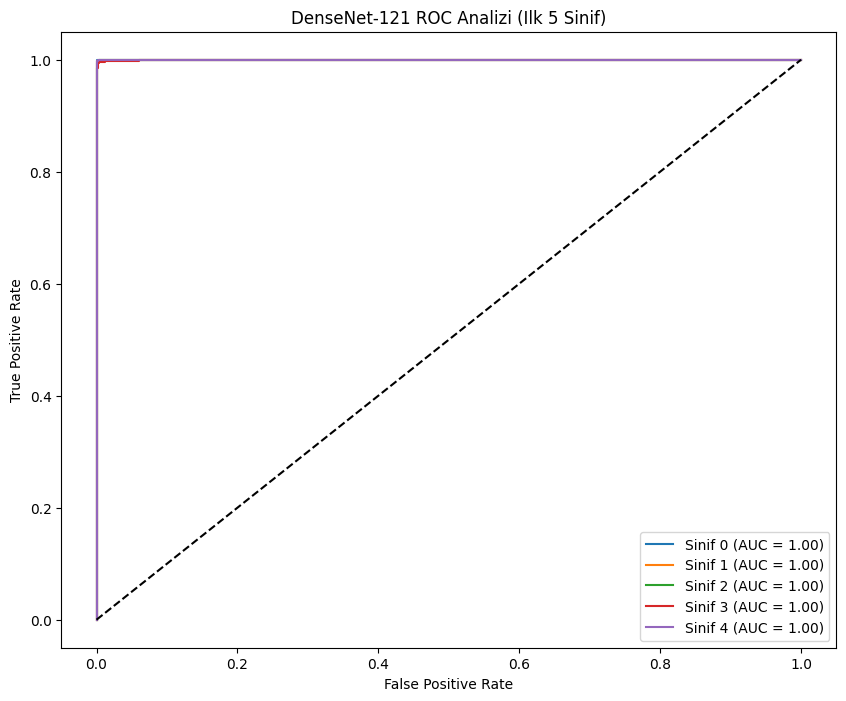

In [9]:
class GTSRBTestDataset(Dataset):
    def __init__(self, csv, root, tf):
        self.data = pd.read_csv(csv, sep=';')
        self.root = root
        self.tf = tf
    def __len__(self): return len(self.data)
    def __getitem__(self, idx):
        img_path = os.path.join(self.root, self.data.iloc[idx, 0])
        image = Image.open(img_path).convert("RGB")
        label = int(self.data.iloc[idx, 7])
        return self.tf(image), label

model.load_state_dict(torch.load(MODEL_PATH))
test_loader = DataLoader(GTSRBTestDataset(TEST_CSV_PATH, TEST_DATA_DIR, test_tf), batch_size=BATCH_SIZE, shuffle=False)

y_true, y_pred, y_probs = evaluate(test_loader)
print("ID | Precision | Recall | F1-Score | Support")
print(classification_report(y_true, y_pred, digits=3))

plt.figure(figsize=(10, 8))
for i in range(5):
    fpr, tpr, _ = roc_curve((np.array(y_true) == i).astype(int), y_probs[:, i])
    plt.plot(fpr, tpr, label=f'Sinif {i} (AUC = {auc(fpr, tpr):.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('DenseNet-121 ROC Analizi (Ilk 5 Sinif)')
plt.legend()
plt.show()